# Classification on EmuCore
#### Device: EmuCore

## Introduction

While classification examples often focus on images (see for example [this tutorial](https://quantumcomputinginc.com/learn/applications/reservoir-computing/image-classification-using-emucore)), there are a number of other applications as well. In this tutorial we demonstrate the use of our reservoir machine for one of these tasks related to automatic speech recognition, an area which has been revolutionized by the [use of neural networks](https://arxiv.org/pdf/2305.00359). In fact recurrent neural networks (RNNs), the class of networks which reservior computers belong to, [have proven particularly useful](https://arxiv.org/pdf/1710.09617) for automated speech recognition tasks (for example in [google home](https://www.cs.cmu.edu/~chanwook/MyPapers/b_li_interspeech_2017.pdf)). RNNs are in fact so effective, that end-to-end RNN models, where all processing is done by the networks without invoking other techniques [have shown great promise](https://arxiv.org/pdf/2004.11544), although transformers have emerged as a [promising alternative](https://arxiv.org/pdf/2305.00359). In this tutorial we apply [QCi's EmuCore](https://quantumcomputinginc.com/learn/developer-resources/reservoir-computing/emucore-direct-software-package/v1.0.6/getting-started) technology, which is an emulated reservior computer to an example where the goal is to recognise emotional sentiment in spoken phrases rather than the phrases themselves, based on [the dataset described here](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0196391).

## Importance

The worldwide market for speech recognition [is already projected to be $7.14 billion in 2024](https://www.statista.com/outlook/tmo/artificial-intelligence/computer-vision/speech-recognition/worldwide#market-size), so tasks related to speech processing certainly have economic value. Reservior computing technology allows for high performance with minimal training [as explained in this lesson](https://quantumcomputinginc.com/learn/lessons/neural-networks-and-reservoir-computing), much less than transformers or more traditional RNNs. This is a major advantage because training an end-to-end automated speech recognition model can [lead to substantial carbon emissions](https://www.isca-archive.org/interspeech_2021/parcollet21_interspeech.pdf). Furthermore, reservoir solutions require relatively little domain expertise to implement. For specialized applications where a new network would have to be trained rather than using an off-the-shelf pre-trained network, reservoir systems therefore provide the potential for a major advantage. Potential advantages, however are not just limited to training, even the energy consumption associated with applying inference in an already trained speech recognition network [can be a challenge](https://arxiv.org/html/2402.13076).

## Applications

Probably most visible application of speech recognition and related technologies is as an interface for software, for example as a digital assistant. In this way users can make requests when their hands are busy or it would otherwise be inconvenient or even impossible to use a more conventional interface like a mouse, keyboard, or remote control. These assistant applications however go beyond just private applications within the home, one important application for example is in [intepreting and recording air traffic control commands](https://www.haawaii.de/wp/wp-content/uploads/2022/12/SID_papaer_2022_starfish_v_1_02.pdf), an important application, because currently about one third of the time of air traffic controllers is spent manually entering data. These technologies are already widely available, and continuously improving. There are however many less obvious applications as well. For example, speech recognition software can be used to [aid in pronounciation training when learning a second language](https://www.frontiersin.org/journals/psychology/articles/10.3389/fpsyg.2023.1210187/full). Another important but far from obvious application is in [assisting those with disorders which affect their speech](https://www.isca-archive.org/interspeech_2021/green21_interspeech.pdf). All of these applications have different requirements and challenges, there will also be many others which we do not mention here. This diversity presents potential opportunities for novel approaches such as reservoir.


## Dataset

In this study, we used the [RAVDESS Emotional Speech Dataset](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0196391). The RAVDESS
dataset consists of 1440 audio files, generated by 24 speakers, which correspond
to 8 different emotion. The aim is build a model that can detect which emotion
an audio file corresponds to.


[https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio)


Copy the files to a directory called "ravdess_files" under the working directory.

## Method

First we import necessary modules

In [ ]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
import glob
from scipy.io import wavfile

# Suppress warnings to keep the output clean
warnings.filterwarnings("ignore")

<h3>Looking for .wav Files</h3>
<h5>This will help find the .wav files in directories and sub-directories.

In [4]:
# Specify the root directory containing subfolders with .wav files
root_dir = "ravdess_files/"  # Replace the path with your Actual Path

# Dictionary to store audio data
audio_data = {}

# Iterate over all subdirectories in the root directory
for subdir, dirs, files in os.walk(root_dir):
    # For each subdirectory, get all .wav files
    wav_files = glob.glob(os.path.join(subdir, "*.wav"))

    for wav_file in wav_files:
        # Load the audio file using wavfile
        sample_rate, audio = wavfile.read(wav_file)
        # Store the audio data in the dictionary
        audio_data[wav_file] = {"audio": audio, "sample_rate": sample_rate}

<h3>Plotting the sample wavfile.

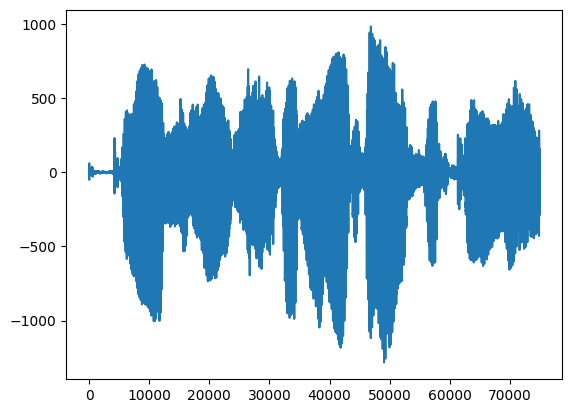

In [5]:
# Convert the audio data to a numpy array with a specific type (float64)
audio = np.array(audio, dtype=np.float64)

# Extract a specific segment of the audio data for analysis (from index 50,001 to 125,000)
audio_segment = audio[50001:125000]

# Plot the audio segment using matplotlib
plt.plot(audio_segment)
plt.show()

<h3> Viewing the data as cochleagram.

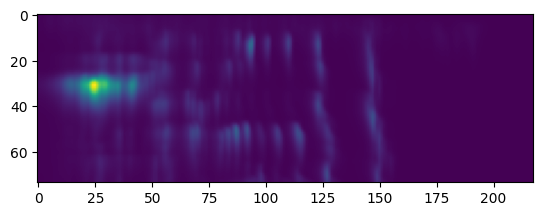

In [7]:
from lyon.calc import LyonCalc

# Create an instance of LyonCalc
calc = LyonCalc()

# Apply the Lyon passive ear model to the audio data to calculate a cochleagram
vec = calc.lyon_passive_ear(
    audio_segment,
    1.0e6,
    decimation_factor=1000,
    ear_q=8,
)

# Convert the result to a numpy array and save it to a file named 'vec.npy'
vec = np.array(vec)
np.save("vec.npy", vec)

# Plot the cochleagram using matplotlib
plt.imshow(vec)
plt.show()

<h3> One hot encoding of labels

In [ ]:
def to_categorical(y, num_classes=None, dtype="float32"):
    """
    Converts a list of labels to a one-hot encoded format.

    Parameters:
    y (array-like): List of labels.
    num_classes (int): Number of classes. If None, it will be inferred from the data.
    dtype (str): Data type of the output array.

    Returns:
    np.ndarray: One-hot encoded representation of the input labels.
    """
    y = np.array(y, dtype="int")
    input_shape = y.shape

    # Reshape if the input shape is (..., 1)
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.reshape(-1)
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

<h3> Searching the audio files in the given directory

In [ ]:
def search_audio_files(folder_path):
    """
    Searches for audio files in the specified directory.

    Parameters:
    folder_path (str): The path to the directory to search for audio files.

    Returns:
    list: A list of filenames of the audio files found in the directory.
    """
    file_names = [
        f for f in listdir(folder_path) if isfile(join(folder_path, f)) and ".wav" in f
    ]
    return file_names

<h3> Determine how to rescale sound data

In [ ]:
def _parse_rescale_arg(rescale):
    """
    Parses the rescale argument and returns the appropriate rescale method.

    Parameters:
    rescale (str): The rescale method to use. Can be 'normalize', 'standardize', or None.

    Returns:
    str: The parsed rescale method.
    """
    if rescale is not None:
        rescale = rescale.lower()
    if rescale == "normalize":
        out_rescale = "normalize"
    elif rescale == "standardize":
        out_rescale = "standardize"
    elif rescale is None:
        out_rescale = None
    else:
        raise ValueError("Unrecognized rescale value: %s" % rescale)
    return out_rescale

<h3>Rescale sound data

In [ ]:
def rescale_sound(snd_array, rescale):
    """
    Rescales the sound data according to the specified rescale method.

    Parameters:
    snd_array (np.ndarray): The sound data to rescale.
    rescale (str): The rescale method to use. Can be 'normalize' or 'standardize'.

    Returns:
    np.ndarray: The rescaled sound data.
    """
    rescale = _parse_rescale_arg(rescale)
    if rescale == "standardize":
        if issubclass(snd_array.dtype.type, np.integer):
            snd_array = snd_array / float(
                np.iinfo(snd_array.dtype).max
            )  # rescale so max value allowed by precision has value 1
        elif issubclass(snd_array.dtype.type, np.floating):
            snd_array = snd_array / float(
                np.finfo(snd_array.dtype).max
            )  # rescale so max value allowed by precision has value 1
        else:
            raise ValueError(
                "rescale is undefined for input type: %s" % snd_array.dtype
            )
    elif rescale == "normalize":
        snd_array = snd_array / float(snd_array.max())  # rescale to [-1, 1]
    return snd_array

<h3> Read wav files and rescale their data

In [ ]:
def wav_to_array(fn, rescale="standardize"):
    """
    Reads a wav file and rescales its data.

    Parameters:
    fn (str): The file path to the wav file.
    rescale (str): The rescale method to use. Can be 'normalize' or 'standardize'.

    Returns:
    tuple: A tuple containing the rescaled sound data (np.ndarray) and the sample frequency (int).
    """
    samp_freq, snd = wavfile.read(fn)
    snd = rescale_sound(snd, rescale)
    return snd, samp_freq

<h3> Convert audio data to a cochleagram

In [ ]:
def convert_to_cochleagram(
    audio_path, decimation_factor=77, n=None, nonlinearity=None, maxLength=None
):
    """
    Converts audio data to a cochleagram.

    Parameters:
    audio_path (str): The file path to the audio file.
    decimation_factor (int): The decimation factor for the cochleagram calculation.
    n (int): The number of frequency channels.
    nonlinearity (str): The type of nonlinearity to apply.
    maxLength (int): The maximum length of the audio data. If None, no padding is applied.

    Returns:
    tuple: A tuple containing the cochleagram (np.ndarray) and a status code (int).
    """
    signal, sample_rate = wav_to_array(audio_path)
    signal = signal[50001:125000]  # Extract a specific segment of the audio data

    fs = 12e3  # Resample frequency
    data = librosa.core.resample(
        y=signal.astype(np.float64), orig_sr=sample_rate, target_sr=fs, res_type="scipy"
    )

    # Zero padding if needed
    if maxLength is not None and len(data) > maxLength:
        err_msg = f"datalength={len(data)}, maxlength={maxLength}, data length cannot exceed padding length."
        print(err_msg)
        return (None, -1)
    elif maxLength is not None and len(data) < maxLength:
        embedded_data = np.zeros(maxLength)
        offset = np.random.randint(low=0, high=maxLength - len(data))
        embedded_data[offset : offset + len(data)] = data
    elif maxLength is not None and len(data) == maxLength:
        embedded_data = data

    if maxLength is not None:
        data = embedded_data

    calc = LyonCalc()

    # Using resampled data to create a cochleagram
    coch = calc.lyon_passive_ear(
        data,
        fs,
        decimation_factor=decimation_factor,
        ear_q=8,
    )
    coch = np.array(coch)
    return (coch, 0)

<h3> Calculate the accuracy of predictions

In [ ]:
def WSR_MSE(target_lst, est_lst):
    """
    Calculates the Weighted Symbol Rate Mean Squared Error (WSR_MSE) between target and estimated labels.

    Parameters:
    target_lst (list): The list of target labels (one-hot encoded).
    est_lst (list): The list of estimated labels (one-hot encoded).

    Returns:
    float: The WSR_MSE value.
    """
    success = 0
    count = 0

    for estimate, target in zip(est_lst, target_lst):
        count += 1
        estimate_index_np_array = np.array(estimate)
        if target[np.argmax(estimate_index_np_array)] == 1:
            success += 1
    wsr = success / count
    return wsr

<h3> Setting up the parameters

Import Libraries: Bring in libraries for file handling, random number generation, timing, numerical operations, data manipulation, and plotting.

Define Audio Directory: Set the path where your audio files are stored.

Set Constants:

NUM_LABELS: The number of different emotions that the model will recognize.
NUM_ACTORS: The total number of actors whose voices are recorded.
NUM_TRAIN_ACTORS: How many actors will be used to train the model.
DECIMATION_FACTOR: A number used to process the audio data (technical detail).
MAX_LENGTH: Maximum length of audio data; None means there is no restriction.
Create Actor List: Make a list of actor numbers from 1 to the total number of actors.

Shuffle Actors: Randomly mix up the order of the actors to ensure training data is diverse.

Select Training Actors: Choose the first few actors from the shuffled list to be used in training the model.

Print Training Actors: Show the list of actors selected for training to verify the choice

In [11]:
# Import necessary libraries for handling files, numbers, and data visualization
import os
import sys
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the directory where audio files are stored
AUDIO_DIR = "ravdess_files/"

# Number of different emotion labels we have
NUM_LABELS = 8

# Total number of actors in the dataset
NUM_ACTORS = 24

# Number of actors to be used for training
NUM_TRAIN_ACTORS = 19

# Decimation factor used for processing audio data
DECIMATION_FACTOR = 77

# Maximum length for audio data (None means no limit)
MAX_LENGTH = None

# List of all actor numbers from 1 to NUM_ACTORS
ACTORS = [i for i in range(1, NUM_ACTORS + 1)]

# Shuffle the list of actors randomly to mix them up
random.shuffle(ACTORS)

# Select the first NUM_TRAIN_ACTORS actors from the shuffled list for training
train_actors = ACTORS[:NUM_TRAIN_ACTORS]

# Print the list of actors chosen for training
print(train_actors)

[19, 1, 11, 18, 21, 6, 8, 13, 7, 20, 16, 22, 23, 3, 24, 17, 12, 4, 14]


<h2>Loading the dataset and preparing to train the model</h2>

Initialize Training and Testing Data: Sets up two dictionaries to store processed data for training and testing.

Iterate Over Audio Files: Processes each audio file, extracts important details from its name, and converts it to a cochleagram.

Save Cochleagram: Saves the cochleagram image for the current audio file.

Check Conversion Success: If the cochleagram conversion fails, the file is skipped.

Convert Emotion Label: Transforms the emotion label into a format used for machine learning (one-hot encoding).

Organize Data: Adds the cochleagram and label to the appropriate set based on whether the actor is part of the training set or not.

Save Data: Saves the organized training and testing data to files.

Prepare Training Data: Combines all cochleagrams and labels from the training set into a format suitable for model training.

In [ ]:
audio_files = audio_data
train_set = {}
test_set = {}

for audio_file in audio_files:
    #print(audio_file)
    #print(len(audio_files))

    # any(isinstance(i, audio_files) for i in audio_files)
    base_name = audio_file.split(".")[0]
    print(base_name)
    tmp_list = base_name.split("-")
    print(tmp_list)
    emotion = int(tmp_list[3])
    emotion_intensity = tmp_list[4]
    statement = tmp_list[5]
    repetition = tmp_list[6]
    actor = int(tmp_list[7])

    print(f"Processing {audio_file}: Actor {actor}, Emotion {emotion}")

    cochleagram, status = convert_to_cochleagram(
        os.path.join(AUDIO_DIR, audio_file),
        decimation_factor=DECIMATION_FACTOR,
        maxLength=MAX_LENGTH,
    )

    np.save("cochleagram", cochleagram)

    print("cochleagram Shape", cochleagram.shape)

    if cochleagram is None:
        print(f"Failed to convert: {audio_file}")
        continue

    label = to_categorical(emotion - 1, num_classes=NUM_LABELS)
    print("Label", label)

    if actor in train_actors:
        train_set[audio_file] = {"coch": cochleagram, "label": label}
    else:
        test_set[audio_file] = {"coch": cochleagram, "label": label}


X_train = None
y_train = None
for file_name in train_set.keys():

    coch = train_set[file_name]["coch"]

    if X_train is None:
        X_train = coch
    else:
        X_train = np.concatenate([X_train, coch])

    label = train_set[file_name]["label"] * 2 - 1
    labels = np.repeat(label.reshape(-1, 1), coch.shape[0], axis=1).T

    if y_train is None:
        y_train = labels
    else:
        y_train = np.concatenate([y_train, labels])

np.save("train_set", train_set)
np.save("test_set", test_set)

<h2>Connecting to EmuCore</h2>

Import Libraries: Bring in libraries needed for file handling, numerical operations, and interacting with the EmuCore system.

Define Parameters: Set up various parameters required to configure and use the EmuCore reservoir computing system.

Create Client: Create a connection to the EmuCore system using its IP address.

Get System Ready: Wait for the EmuCore system to be ready and get a lock to make changes.

Reset and Configure Reservoir: Reset the reservoir to its initial state and configure it with the defined parameters.

Load Data: Load previously saved training and testing data from files.

Process Training Data: For each training data file:

Check if the number of features matches the expected number.
Process the data through the reservoir.
Update the training data with the processed results.
Verify that the number of features in the output data is correct.
Process Testing Data: Similarly, process the testing data and update it.

Save Processed Data: Save the processed training and testing data to new files for future use.

In [ ]:
# Import necessary libraries for handling files and numerical operations
import os
import numpy as np
from emucore_direct.client import EmuCoreClient

# Define parameters for the reservoir computing system
IP_ADDR = "172.18.41.60"  # IP address of the EmuCore system
VBIAS = 0.3  # Voltage bias for the reservoir
GAIN = 0.65  # Gain setting for the reservoir
NUM_NODES = 800  # Number of nodes in the reservoir
NUM_TAPS = NUM_NODES  # Number of taps in the reservoir (same as number of nodes)
FEATURE_SCALING = 0.5  # Scaling factor for the features
DENSITY = 1  # Density of connections in the reservoir

NUM_F = 77  # Number of features in the input data

# Create a client to interact with the EmuCore system
client = EmuCoreClient(ip_addr=IP_ADDR)

# Wait for the system to be ready and get a lock
lock_id, start, end = client.wait_for_lock()

# Reset the reservoir to its initial state
client.reservoir_reset(lock_id=lock_id)

# Configure the reservoir with the specified settings
client.rc_config(
    lock_id=lock_id, vbias=VBIAS, gain=GAIN, num_nodes=NUM_NODES, num_taps=NUM_TAPS
)

# Load the training and testing data from saved files
train_set = np.load("train_set.npy", allow_pickle=True).item()
test_set = np.load("test_set.npy", allow_pickle=True).item()

# Process the training data using the reservoir computing system
for item in train_set.keys():
    #print("Train", item)  # Print the current training file being processed

    # Ensure that the number of features in the input data matches the expected number
    assert train_set[item]["coch"].shape[1] == NUM_F

    # Process the data through the reservoir
    X_trans_response, _, _ = client.process_all_data(
        input_data=train_set[item]["coch"],
        num_nodes=NUM_NODES,
        density=DENSITY,
        feature_scaling=FEATURE_SCALING,
        lock_id=lock_id,
    )

    # Update the training data with the processed results
    train_set[item]["coch"] = X_trans_response

    # Ensure the number of features in the output data matches the number of nodes
    assert train_set[item]["coch"].shape[1] == NUM_NODES

# Process the testing data in the same way
for item in test_set.keys():
    print("Test", item)  # Print the current testing file being processed

    # Ensure that the number of features in the input data matches the expected number
    assert test_set[item]["coch"].shape[1] == NUM_F

    # Process the data through the reservoir
    X_trans_response, _, _ = client.process_all_data(
        input_data=test_set[item]["coch"],
        num_nodes=NUM_NODES,
        density=DENSITY,
        feature_scaling=FEATURE_SCALING,
        lock_id=lock_id,
    )

    # Update the testing data with the processed results
    test_set[item]["coch"] = X_trans_response

    # Ensure the number of features in the output data matches the number of nodes
    assert test_set[item]["coch"].shape[1] == NUM_NODES

# Save the processed training and testing data to new files
np.save("train_set_ravdess_reservoir2.npy", train_set)
np.save("test_set_ravdess_reservoir2.npy", test_set)

<h2>Loading the High Dimensional Data from EmuCore</h2>
Import Libraries:

These are the tools we'll use for building machine learning models and handling data.
sklearn is a popular library for machine learning in Python.
numpy is used for working with numerical data.
Define Possible Values:

These lists define possible categories or labels for certain features in your dataset.
They help in understanding or classifying the data.
Load Data:

We read the training and testing data from files that were saved earlier.
The np.load function is used to load the data, and allow_pickle=True lets us read Python objects stored in the files.
.item() converts the loaded data into a dictionary so that we can easily work with it.

In [10]:
# Import necessary libraries for machine learning and numerical operations
import os
import sys
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
)  # For linear and logistic regression models
from sklearn.metrics import accuracy_score  # To measure the accuracy of our models
from sklearn.ensemble import RandomForestClassifier  # For random forest classification
from sklearn.tree import DecisionTreeClassifier  # For decision tree classification
from sklearn.svm import SVC  # For support vector classification
import numpy as np  # For handling numerical data

# Define possible values for certain features
STATEMENTS = ["01", "02"]  # Different statements in the dataset
INTENSITIES = ["01", "02"]  # Different intensity levels in the dataset
REPETITIONS = ["01", "02"]  # Different repetitions in the dataset

# Load the training and testing data from saved files
train_set = np.load(
    "train_set_ravdess_reservoir2.npy",  # File containing training data
    allow_pickle=True,  # Allows loading of Python objects from the file
).item()  # Convert the loaded data to a Python dictionary

test_set = np.load(
    "test_set_ravdess_reservoir2.npy",  # File containing testing data
    allow_pickle=True,  # Allows loading of Python objects from the file
).item()  # Convert the loaded data to a Python dictionary

Initialize Variables:

X_train will store all the cochleagram data (features) from the training set.
y_train will store all the corresponding labels for the training data.
Loop Through Each Training File:

For each file in the training set, get the cochleagram data (features) and labels.
Concatenate Data:

If X_train is empty, start it with the current cochleagram data.
If X_train already has data, add the current cochleagram data to it.
Similarly, handle y_train by repeating and concatenating labels to match the cochleagram data.
Label Adjustment:

Adjust labels to be in the range of {-1, 1} for consistency in some machine learning models.
Use np.repeat to match the shape of the cochleagram data.

In [11]:
# Initialize variables to store training data and labels
X_train = None  # This will hold the concatenated feature data for training
y_train = None  # This will hold the concatenated labels for training

# Loop through each file in the training dataset
for file_name in train_set.keys():

    # Get the cochleagram data for the current file
    coch = train_set[file_name]["coch"]

    # If X_train is empty, initialize it with the current cochleagram data
    if X_train is None:
        X_train = coch
    else:
        # If X_train already has data, add the current cochleagram data to it
        X_train = np.concatenate([X_train, coch])

    # Get the label for the current file, adjust it to be in the range {-1, 1}
    label = train_set[file_name]["label"] * 2 - 1

    # Repeat the label to match the shape of the cochleagram data
    labels = np.repeat(label.reshape(-1, 1), coch.shape[0], axis=1).T

    # If y_train is empty, initialize it with the current labels
    if y_train is None:
        y_train = labels
    else:
        # If y_train already has data, add the current labels to it
        y_train = np.concatenate([y_train, labels])

<h2>Create a Linear Regression Model:</h2>

LinearRegression(fit_intercept=True): This line creates a linear regression model object. The fit_intercept=True means the model will include an intercept in the regression line.
Train the Model:

clf.fit(X_train, y_train): This trains the model using your training data (X_train) and the corresponding labels (y_train). Essentially, it learns the relationship between the features and the labels.
Evaluate the Model:

score = clf.score(X_train, y_train): This measures how well the trained model performs on the training data. The score typically ranges from 0 to 1, where 1 means perfect prediction and 0 means the model is no better than random guessing.

In [12]:
from sklearn.linear_model import LinearRegression

# Create a Linear Regression model
clf = LinearRegression(fit_intercept=True)

# Train the model using the training data and labels
clf.fit(X_train, y_train)

# Evaluate the model's performance on the training data
score = clf.score(X_train, y_train)

<h2>Process Training Data:</h2>

Initialize Lists: y_train to store true labels and y_train_prd to store predicted values for the training data.
Filter and Process: For each file, check if it meets the criteria (repetition, statement, intensity). If it does, append the true label and the model’s prediction (average over features) to the lists.
Evaluate Training Data:

Calculate and print the success rate (accuracy) for the training data using WSR_MSE, which measures how well the predictions match the actual labels.
Process Test Data:

Initialize Lists: y_test for true labels and y_test_prd for predicted values for the test data.
Filter and Process: For each file, check if it meets the criteria (similar to training data). Append the true label and the model’s prediction to the lists.
Evaluate Test Data:

Calculate and print the success rate (accuracy) for the test data using WSR_MSE, similar to the training data evaluation.

In [13]:
# Lists to store actual labels and predicted values for training data
y_train = []
y_train_prd = []

# Process each file in the training dataset
for file_name in train_set.keys():

    # Get the base name of the file (remove the file extension)
    base_name = file_name.split(".")[0]

    # Skip files that do not match the expected criteria
    if base_name.split("-")[5] not in REPETITIONS:
        continue
    if base_name.split("-")[4] not in STATEMENTS:
        continue
    if base_name.split("-")[3] not in INTENSITIES:
        continue

    # Get the features (cochleagrams) and append the label
    X_train_tmp = train_set[file_name]["coch"]
    X_train_tmp = np.array(X_train_tmp)  # Convert to numpy array
    y_train.append(train_set[file_name]["label"] * 2 - 1)

    # Predict using the model and take the average prediction for the features
    y_train_prd.append(clf.predict(X_train_tmp).mean(axis=0))

# Print the success rate on the training data
print(
    "Success rate on train data: %0.3f"
    % (WSR_MSE(y_train, y_train_prd))  # This function computes the error rate
)

# Lists to store actual labels and predicted values for test data
y_test = []
y_test_prd = []

# Process each file in the test dataset
for file_name in test_set.keys():

    # Get the base name of the file (remove the file extension)
    base_name = file_name.split(".")[0]

    # Skip files that do not match the expected criteria
    if base_name.split("-")[5] not in REPETITIONS:
        continue
    if base_name.split("-")[4] not in STATEMENTS:
        continue
    if base_name.split("-")[3] not in INTENSITIES:
        continue

    # Get the features (cochleagrams) and append the label
    X_test_tmp = test_set[file_name]["coch"]
    y_test.append(test_set[file_name]["label"] * 2 - 1)

    # Predict using the model and take the average prediction for the features
    y_test_prd.append(clf.predict(X_test_tmp).mean(axis=0))

# Print the success rate on the test data
print(
    "Success rate on test data: %0.3f"
    % (WSR_MSE(y_test, y_test_prd))  # This function computes the error rate
)

Success rate on train data: 0.654
Success rate on test data: 0.517


## Conclusions
In this tutorial we have demonstrated one example of an application of our [EmuCore device](https://quantumcomputinginc.com/learn/reference-documentation/emucore-direct/v1.0.6/getting-started) which emulates an [analog reservoir computer](https://quantumcomputinginc.com/learn/lessons/reservoir-computing-overview) to a speech classification task. If you want another example of EmuCore's capabilities, we encourage you to look at [this tutorial](https://quantumcomputinginc.com/learn/applications/reservoir-computing/image-classification-using-emucore) where the device is used to classify images rather than speech. For more machine-learning related applications on other hardware, we encourage you to look at some of the materials for the Dirac devices, in particular, [this tutorial](https://quantumcomputinginc.com/learn/developer-resources/entropy-quantum-optimization/qboost-formulation) which uses a different machine learning method known as boosting. In that tutorial boosting is used to identify plants based on visual data. Another option is to start applying EmuCore (or Dirac) to a problem of your own. 